In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.layers import Input, Dense
from keras.models import Model
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import warnings
warnings.filterwarnings('always')

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
import numpy as np
(X_train, _), (X_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
# fs_image = np.random.shuffle(fs_images)
# X_train , X_test = fs_images[:375], fs_images[375:]
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_test = X_test.reshape((X_test.shape[0], 28*28))

In [4]:
#Normalize the dataset
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


### Sample Visualization

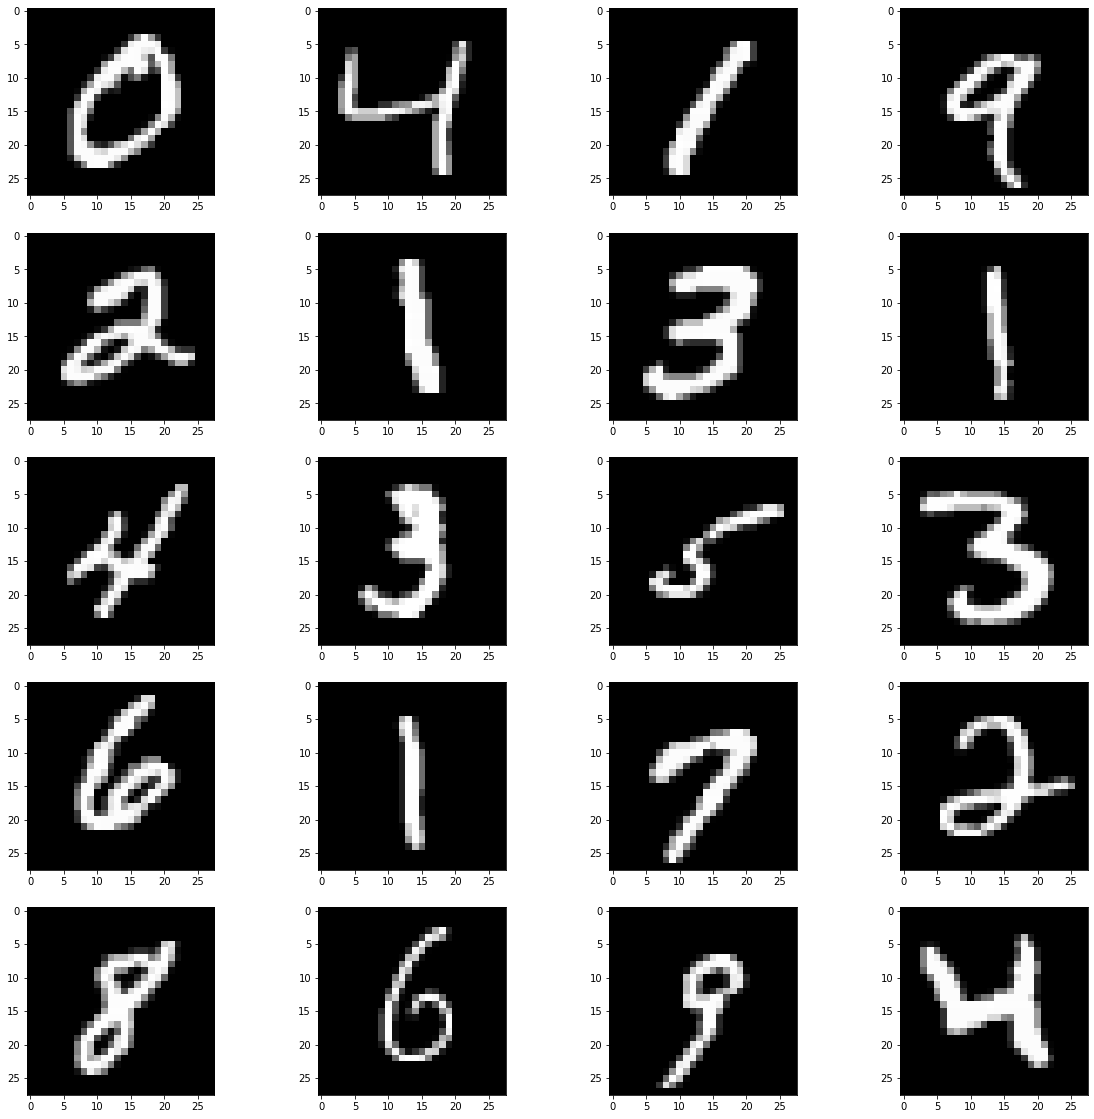

In [5]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = X_train[i].reshape(28,28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

## PCA for image Rerconstruction

- Ref1: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
- Ref2: https://stats.stackexchange.com/a/229093

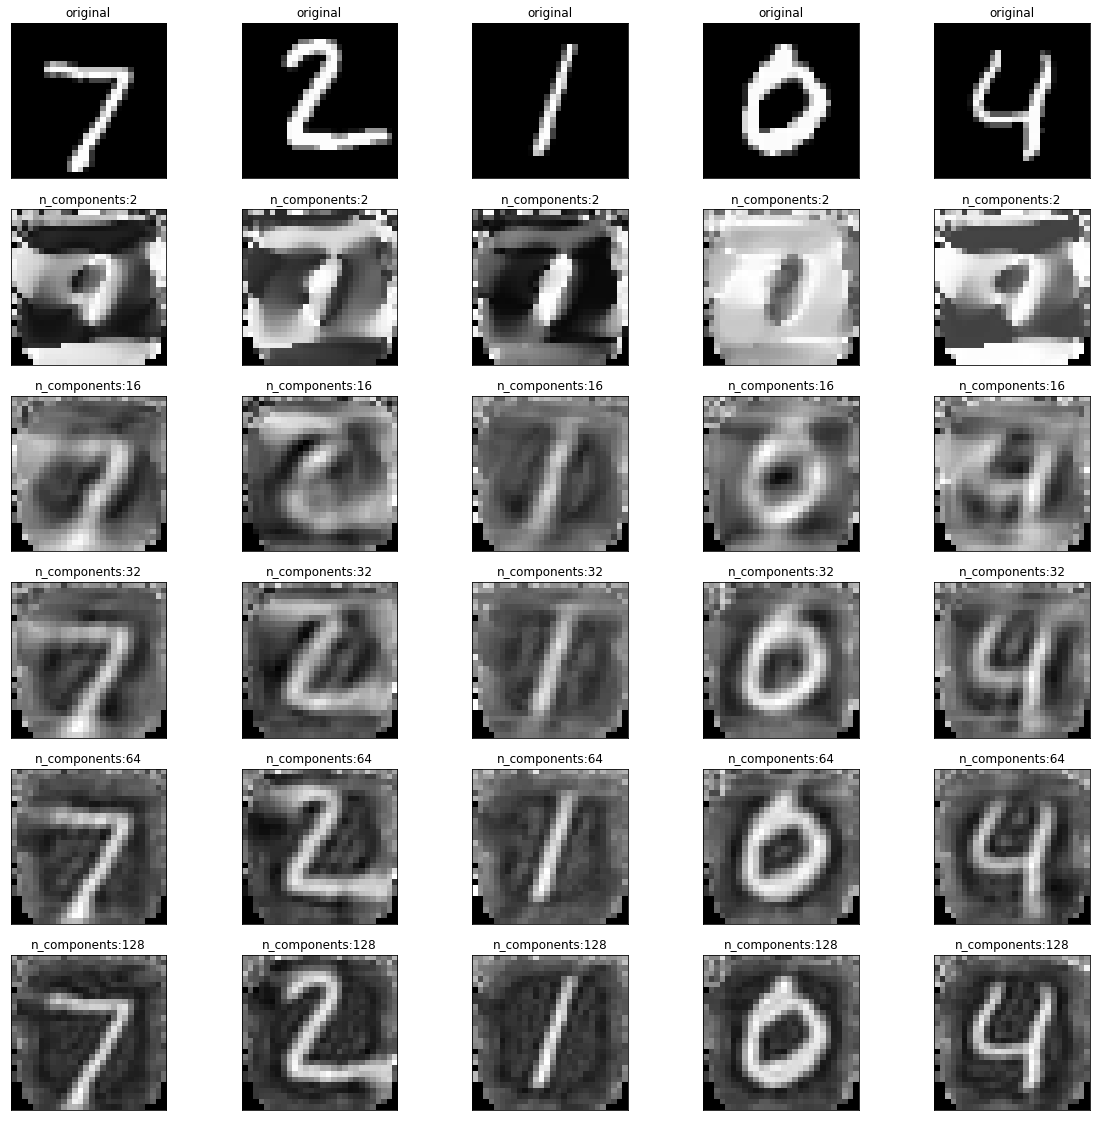

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg as LA
reconst_loss=[]

n_comp = 150
n = 5  # how many Images we will display
comp = [2, 16, 32, 64,128]
f, ax = plt.subplots(len(comp)+1,5, figsize=(20,20))

for i in range(n):

    ax[0][i].imshow(X_test[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax[0][i].get_xaxis().set_visible(False)
    ax[0][i].get_yaxis().set_visible(False)
    ax[0][i].set_title('original')

pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(X_train)

for i,v in enumerate(comp):
    # Image reconstruction with v components
    
    X_test_inv = np.dot(pca.transform(X_test)[:,:v], pca.components_[:v,:])
    X_test_inv = MinMaxScaler(feature_range=(0,1)).fit_transform(X_test_inv)

    for j in range(n):
        ax[i+1][j].imshow(X_test_inv[j].reshape(28,28), cmap=plt.get_cmap('gray'))
        ax[i+1][j].get_xaxis().set_visible(False)
        ax[i+1][j].get_yaxis().set_visible(False)
        ax[i+1][j].set_title('n_components:'+str(v), fontsize=12)
        
    total_loss= LA.norm((X_test-X_test_inv),None)
    reconst_loss.append(total_loss)
plt.show()

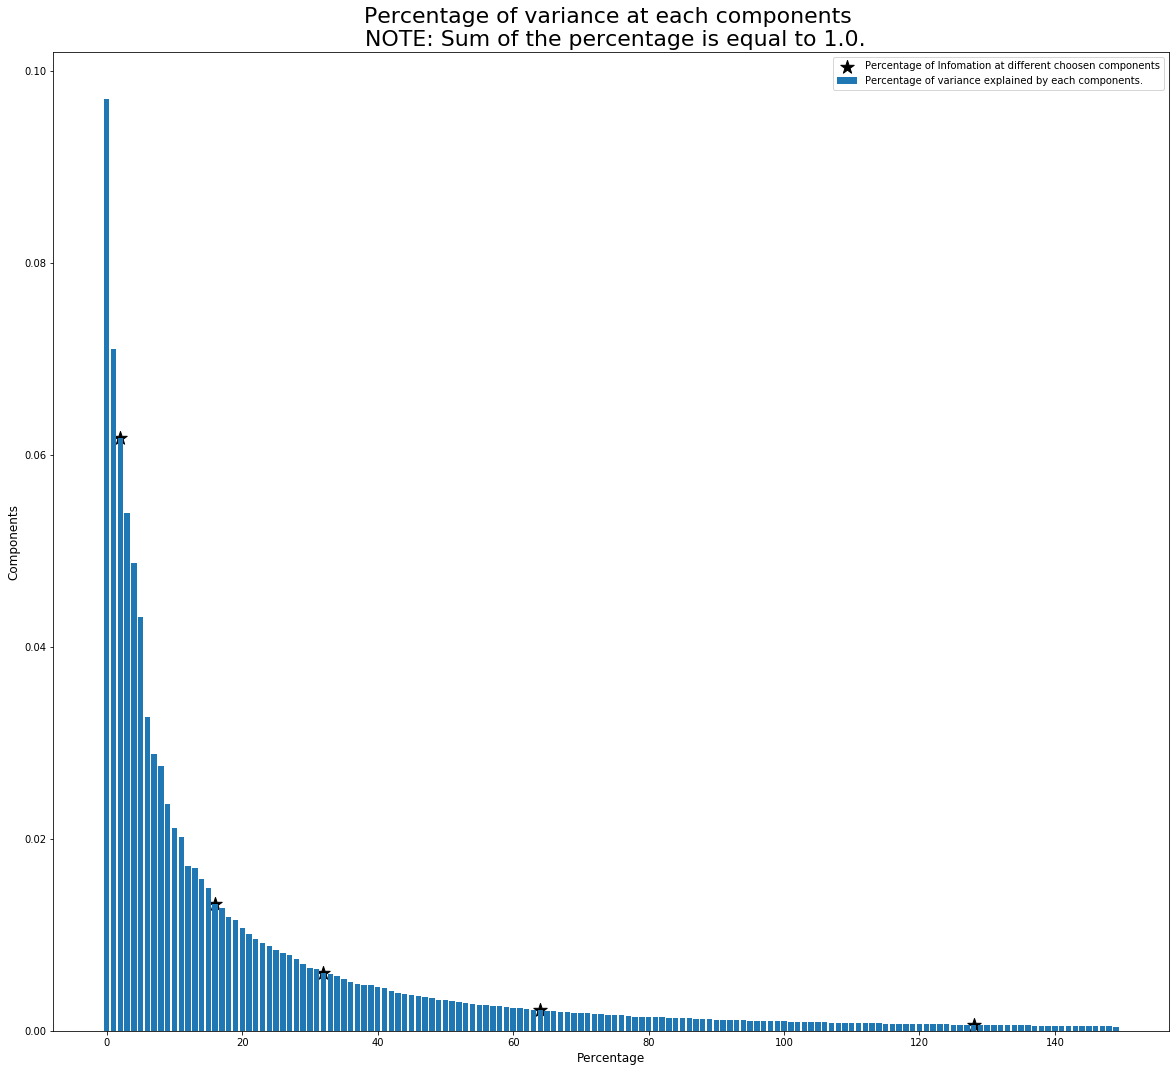

In [8]:
plt.figure(figsize=(20,18))

plt.bar([i for i in range(n_comp)], pca.explained_variance_ratio_ , label="Percentage of variance explained by each components.")
plt.scatter(comp , pca.explained_variance_ratio_[comp], c="black", marker="*", s=200, label="Percentage of Infomation at different choosen components")
plt.title("Percentage of variance at each components \n NOTE: Sum of the percentage is equal to 1.0.", fontsize=22)
plt.xlabel("Percentage", fontsize=12)
plt.ylabel("Components", fontsize=12)
plt.legend()
plt.show()

##### A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components

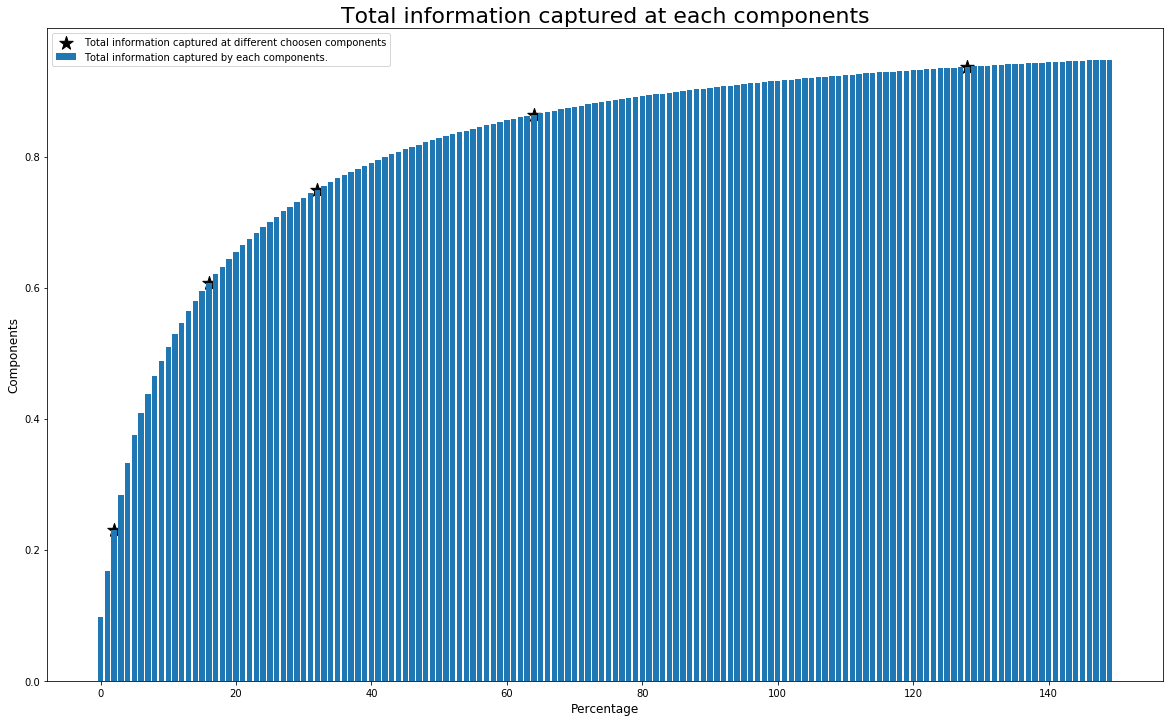

In [9]:
import itertools
import operator
plt.figure(figsize=(20,12))
pca_total_info = np.array(list(itertools.accumulate(pca.explained_variance_ratio_, operator.add))) 


plt.bar([i for i in range(n_comp)], pca_total_info , label="Total information captured by each components.")
plt.scatter(comp , pca_total_info[comp], c="black", marker="*", s=200, label="Total information captured at different choosen components")
plt.title("Total information captured at each components", fontsize=22)
plt.xlabel("Percentage", fontsize=12)
plt.ylabel("Components", fontsize=12)
plt.legend()
plt.show()

## Autoencoder

In [0]:
def get_autoencoder(dim):
    encoding_dim = dim  # 32 floats 

    # this is our input placeholder
    input_img = Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(784, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    print(autoencoder.summary())
    return autoencoder

In [11]:
image_pred = []
for i in comp:
    autoencoder = get_autoencoder(i)
    autoencoder.fit(X_train, X_train,
                    epochs=30,
                    batch_size=128,
                    shuffle=True,
                    verbose=1)
    img_pred = autoencoder.predict(X_test)
    image_pred.append(img_pred)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
None



Epoch 1/30





60000/60000 [==============================] - 4s 75us/step - loss: 0.3305
Epoch 2/30
60000/60000 [==============================] - 4s 63us/step - loss: 0.2582
Epoch 3/30
60000/60000 [==============================] - 4s 64us/step - loss: 0.2480
Epoch 4/30
60000/

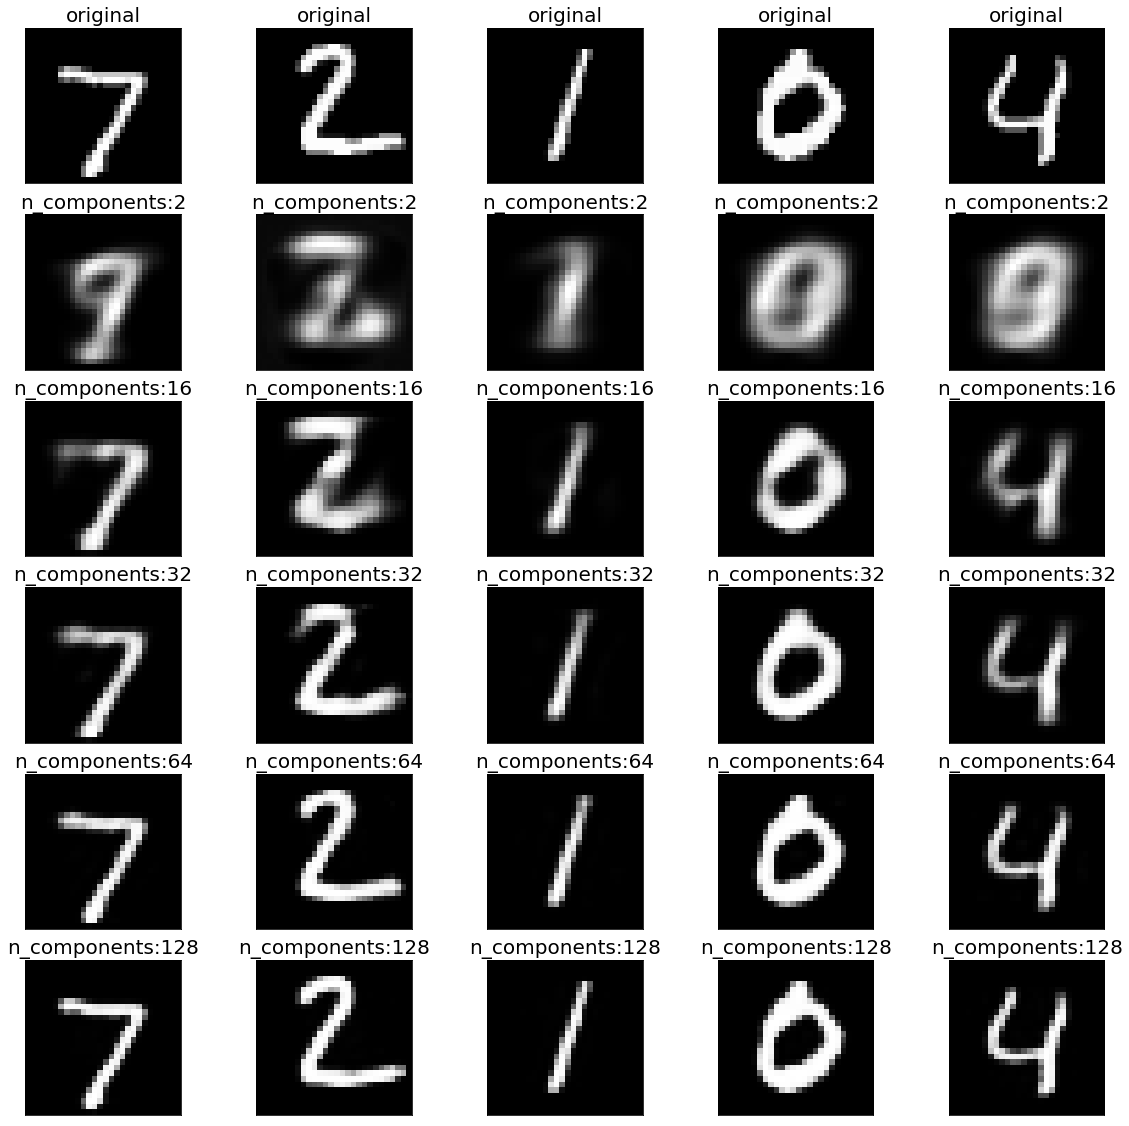

In [12]:
from numpy import linalg as LA
reconst_loss_auto=[]

f, ax = plt.subplots(len(comp)+1,5, figsize=(20,20))
for i in range(n):

    ax[0][i].imshow(X_test[i].reshape(28,28),cmap=plt.get_cmap('gray'))
    ax[0][i].get_xaxis().set_visible(False)
    ax[0][i].get_yaxis().set_visible(False)
    ax[0][i].set_title('original', fontsize=20)

for i,v in enumerate(comp):
    # Image reconstruction with v components
    
    X_reconst = image_pred[i]

    for j in range(n):
        ax[i+1][j].imshow(X_reconst[j].reshape(28,28),cmap=plt.get_cmap('gray'))
        ax[i+1][j].get_xaxis().set_visible(False)
        ax[i+1][j].get_yaxis().set_visible(False)
        ax[i+1][j].set_title('n_components:'+str(v), fontsize=20)
        
    total_loss= LA.norm((X_test-X_reconst),None)
    reconst_loss_auto.append(total_loss)

plt.show()


## Comparison of Reconstruction: PCA vs AutoEncoder

### Bar plot of Total Euclidean distance at different components: PCA vs Autoencoder

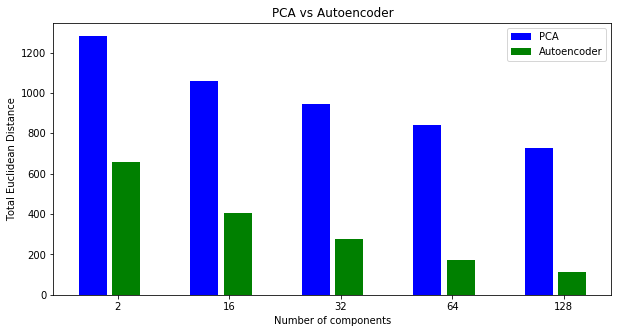

In [13]:
pos = list(range(len(comp))) 
width = 0.25

# plt.figure(figsize=(6,6))
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(pos, reconst_loss, width=0.25, color='b', label='PCA', align='center')
plt.bar([p + 1.2*width for p in pos], reconst_loss_auto, width=0.25, color='g', label='Autoencoder', align='center')


ax.set_xticks([p + 0.9 * width for p in pos])
ax.set_xticklabels([str(i) for i in comp])

ax.set_title('PCA vs Autoencoder')
ax.set_xlabel("Number of components")
ax.set_ylabel("Total Euclidean Distance")
plt.legend()

plt.show()

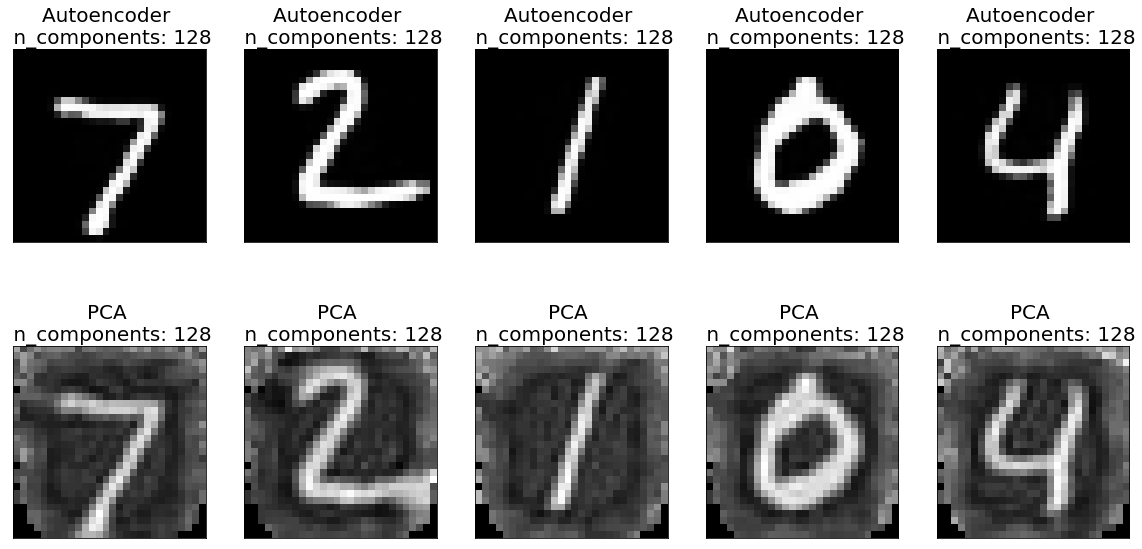

In [14]:
f, ax = plt.subplots(2,5, figsize=(20,10))
for j in range(5):
    
    ax[1][j].imshow(X_test_inv[j].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax[1][j].get_xaxis().set_visible(False)
    ax[1][j].get_yaxis().set_visible(False)
    ax[1][j].set_title('PCA \n n_components: 128', fontsize=20)
    
    ax[0][j].imshow(image_pred[-1][j].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax[0][j].get_xaxis().set_visible(False)
    ax[0][j].get_yaxis().set_visible(False)
    ax[0][j].set_title('Autoencoder \n n_components: 128', fontsize=20)
    
    

## Denoising Autoencoderers

In [0]:
# noise = np.random.normal(loc=0, scale=0.1, size=X_train.shape)
# X_train_noisy = X_train + noise
# noise = np.random.normal(loc=0, scale=0.1, size=X_test.shape)
# X_test_noisy = X_test + noise
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### Sample Visualization

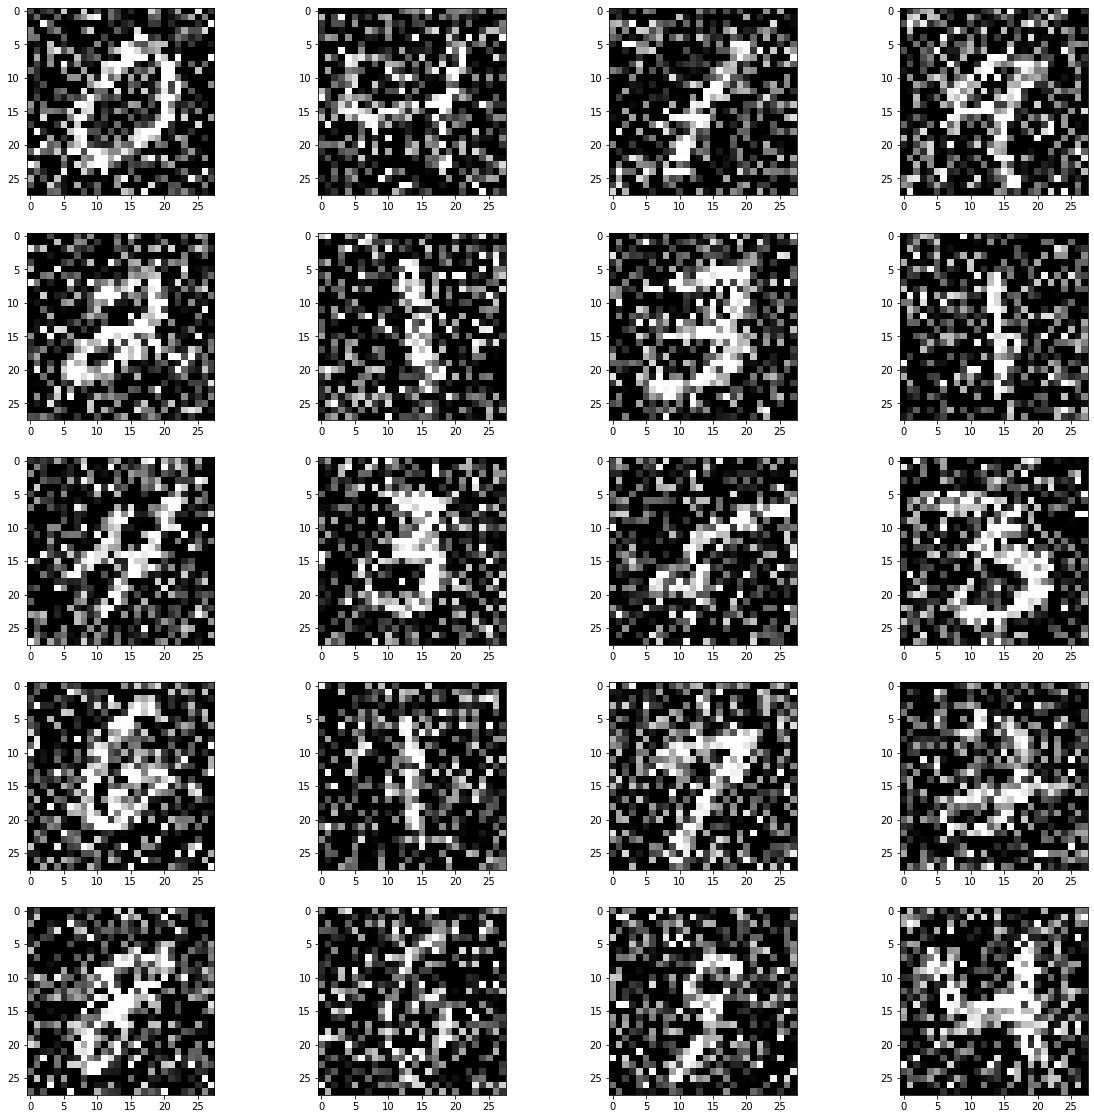

In [16]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = X_train_noisy[i].reshape(28,28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

In [17]:
image_pred_de = []
for i in comp:
    autoencoder = get_autoencoder(i)
    autoencoder.fit(X_train_noisy, X_train,
                    epochs=30,
                    batch_size=128,
                    shuffle=True,
                    verbose=1)
    img_pred = autoencoder.predict(X_test_noisy)
    image_pred_de.append(img_pred)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 1570      
_________________________________________________________________
dense_12 (Dense)             (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
60000/60000 [==============================] - 5s 83us/step - loss: 0.3278
Epoch 2/30
60000/60000 [==============================] - 4s 68us/step - loss: 0.2662
Epoch 3/30
60000/60000 [==============================] - 4s 67us/step - loss: 0.2521
Epoch 4/30
60000/60000 [==============================] - 4s 68us/step - loss: 0.2450
Epoch 5/30
60000/60000 [==============

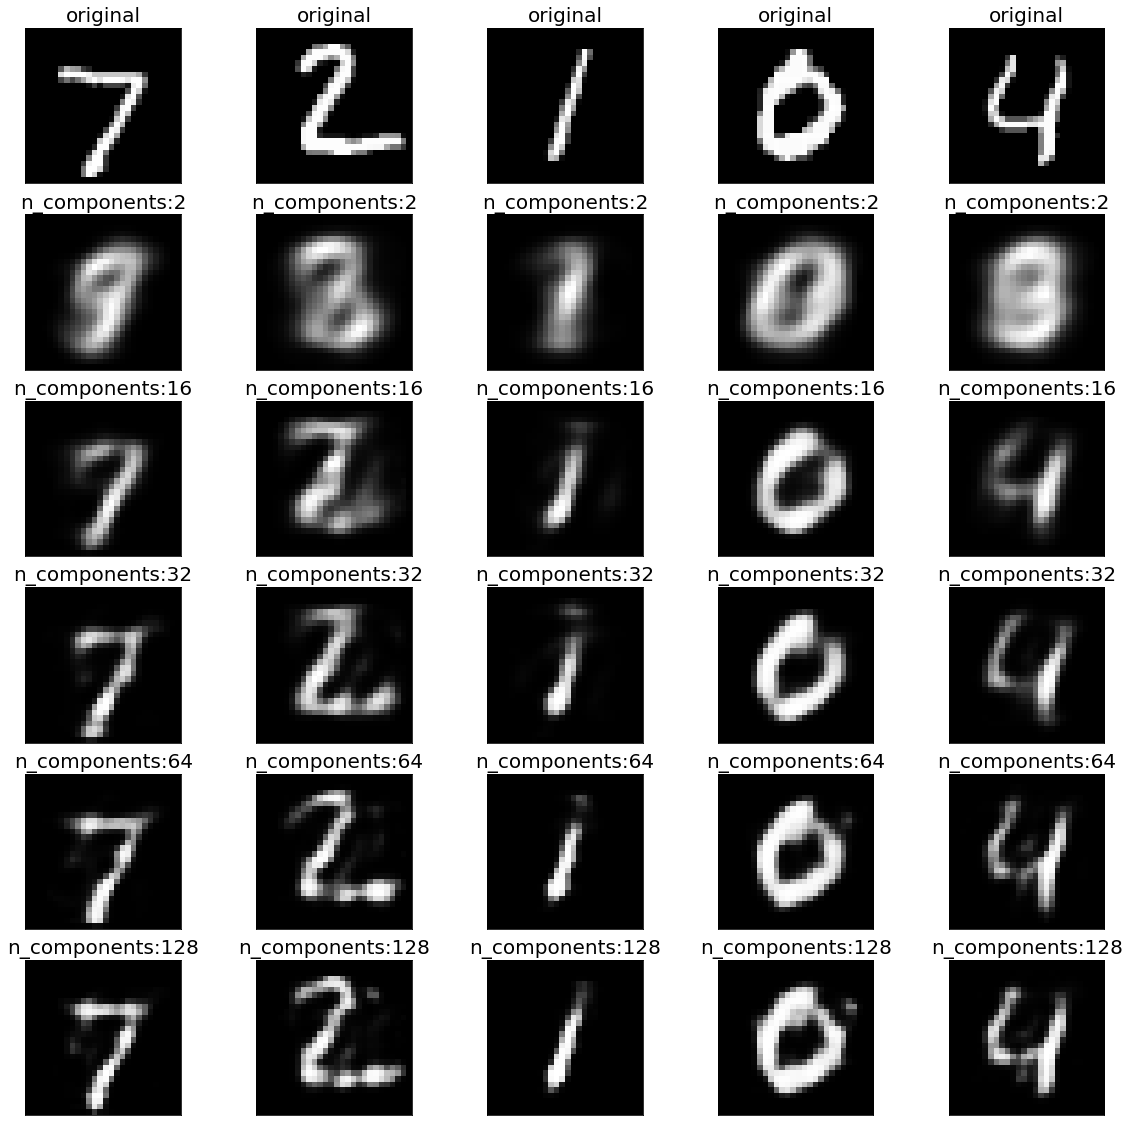

In [18]:
from numpy import linalg as LA
reconst_loss_auto_de=[]

f, ax = plt.subplots(len(comp)+1,5, figsize=(20,20))
for i in range(n):

    ax[0][i].imshow(X_test[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax[0][i].get_xaxis().set_visible(False)
    ax[0][i].get_yaxis().set_visible(False)
    ax[0][i].set_title('original', fontsize=20)

for i,v in enumerate(comp):
    # Image reconstruction with v components
    
    X_reconst = image_pred_de[i]

    for j in range(n):
        ax[i+1][j].imshow(X_reconst[j].reshape(28,28), cmap=plt.get_cmap('gray'))
        ax[i+1][j].get_xaxis().set_visible(False)
        ax[i+1][j].get_yaxis().set_visible(False)
        ax[i+1][j].set_title('n_components:'+str(v), fontsize=20)
        
    total_loss= LA.norm((X_test-X_reconst),None)
    reconst_loss_auto_de.append(total_loss)

plt.show()


## Comparison of Reconstruction: PCA vs Autoencoder vs Denoising Autoencoder

### Bar plot of Total Euclidean distance at different components: PCA vs Autoencoder vs Denoising Autoencoder

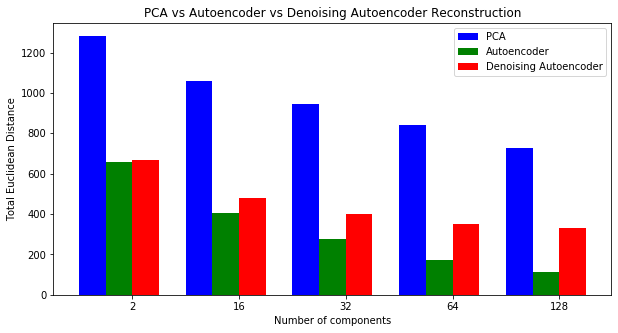

In [19]:
pos = list(range(len(comp))) 
width = 0.25

# plt.figure(figsize=(6,6))
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(pos, reconst_loss, width=0.25, color='b', label='PCA', align='center')
plt.bar([p + width for p in pos], reconst_loss_auto, width=0.25, color='g', label='Autoencoder', align='center')
plt.bar([p + 2*width for p in pos], reconst_loss_auto_de, width=0.25, color='r', label='Denoising Autoencoder', align='center')

ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels([str(i) for i in comp])

ax.set_title('PCA vs Autoencoder vs Denoising Autoencoder Reconstruction')
ax.set_xlabel("Number of components")
ax.set_ylabel("Total Euclidean Distance")
plt.legend()

plt.show()

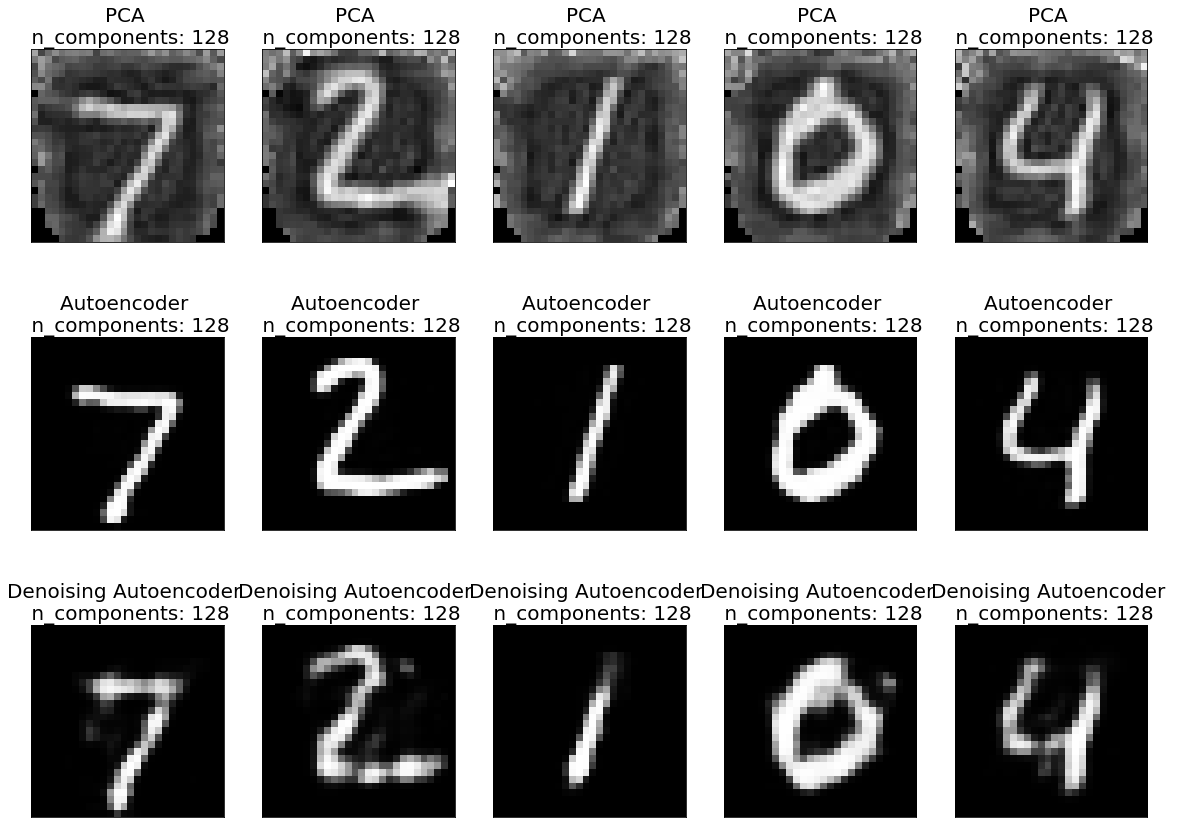

In [20]:
f, ax = plt.subplots(3,5, figsize=(20,15))
for j in range(5):
    
    ax[0][j].imshow(X_test_inv[j].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax[0][j].get_xaxis().set_visible(False)
    ax[0][j].get_yaxis().set_visible(False)
    ax[0][j].set_title('PCA \n n_components: 128', fontsize=20)
    
    ax[1][j].imshow(image_pred[-1][j].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax[1][j].get_xaxis().set_visible(False)
    ax[1][j].get_yaxis().set_visible(False)
    ax[1][j].set_title('Autoencoder \n n_components: 128', fontsize=20)
    
    ax[2][j].imshow(image_pred_de[-1][j].reshape(28,28),cmap=plt.get_cmap('gray'))
    ax[2][j].get_xaxis().set_visible(False)
    ax[2][j].get_yaxis().set_visible(False)
    ax[2][j].set_title('Denoising Autoencoder \n n_components: 128', fontsize=20)

In [0]:
# input_img = Input(shape=(30000,))
# encoded = Dense(2048, activation='relu')(input_img)
# # encoded = Dense(1024, activation='relu')(encoded)
# encoded = Dense(1024, activation='relu')(encoded)

# # decoded = Dense(1024, activation='relu')(encoded)
# decoded = Dense(2048, activation='relu')(encoded)
# decoded = Dense(30000, activation='sigmoid')(decoded)
# autoencoder_deep = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder_deep.summary()
# return autoencoder

In [0]:
# autoencoder_deep.fit(X_train, X_train,
#                 epochs=50,
#                 batch_size=64,
#                 shuffle=True,
#                 validation_data=(X_val, X_val),
#                 verbose=1)